In this notebook, we track the changes in annotations between the _master_ and [v3.0.0-alpha](https://github.com/MTG/otmm_tonic_dataset/tree/v3.0.0-alpha). _v3.0.0-alpha_ is the pre-release of the dataset when all the tonic test datasets had been merged prior to annotation verification.

In [1]:
import urllib2
import json
import numpy as np
from unittests.validate_annotations import test_annotations
import warnings
from morty.converter import Converter
from morty.pitchdistribution import PitchDistribution
from matplotlib import pyplot as plt


In [2]:
# load master data
anno_master = json.load(open('../annotations.json'))

# load v3.0.0-alpha data
anno_alpha_url = 'https://raw.githubusercontent.com/MTG/otmm_tonic_dataset/v3.0.0-alpha/annotations.json'
response = urllib2.urlopen(anno_alpha_url)
anno_alpha = json.load(response)


First, we run the [automatic validation tests](https://github.com/MTG/otmm_tonic_dataset/blob/master/unittests/validate_annotations.py#L11) on _master_ to find how many recordings get the current validation reports. Note that it is also done by [Travis CI](https://travis-ci.org/MTG/otmm_tonic_dataset). Here we run it for the sake of completeness.

In [3]:
test_annotations(anno_master)

INFO:root:- Validating 1994 recordings


The _master_ does not have any tonic frequency mismatches in the 908 recordings tested out of 1994. By this test, validation %45 of the dataset is tested automatically. 

Next, we run the [automatic validation tests](https://github.com/MTG/otmm_tonic_dataset/blob/master/unittests/validate_annotations.py#L11) on _v3.0.0-alpha_ to find how many recordings had annotation inconsistencies before verification.

In [4]:
try:
    test_annotations(anno_alpha)
except AssertionError as err:
    # get the number of mismatches
    print err
    num_err = [int(s) for s in err.args[0].split() if s.isdigit()][0]
    inconsistent_percent = float(num_err) * 100 / (2007-1589)  # taken from the penultimate warning
    print("The human annotators show inconsistencies in {:.1f}% of "
          "the {:d} tested recordings.".format(inconsistent_percent, 2007-1589))
    


INFO:root:- Validating 2007 recordings
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/5a44e069-3b0e-4a28-b515-b7b257b6373a
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/428a80a9-d545-4ad3-9324-237368bcf027
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/5f11df16-816d-4253-ae6d-04f6ed0ed309
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/52fb0080-4c80-44c0-858a-46e4a4bded0a
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/d622b79a-a6f8-40f9-b002-3b68890e4e25
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/b0ff86ee-25ca-415e-b377-84038efe43a9
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/9c9d3440-011b-4357-9eb7-303a8aeb5e8f
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/d2ebf684-8b56-418c-866a-0fa6b8acda1e
ERROR:root:> Mismatch in http://dunya.compmusic.upf.edu/makam/recording/632656b7-6a0f-476

Annotations in 23 recording(s) are inconsistent
The human annotators show inconsistencies in 5.5% of the 418 tested recordings.


As can be seen _v3.0.0-alpha_ has inconsistencies in the annotation of 23 recordings according to the automatic tests. Nevertheless, there are some additional cases, which are not found by the automatic validation. Therefore the automatic validation result above must be interpreted as the minimum number of recordings with inconsistencies. Below the two major reasons are explained:

- In _v3.0.0-alpha_, there were several recordings, where the tonic frequency/symbol varies throughout the recording (e.g. [Isfahan Peşrev by Mesut Cemil](http://musicbrainz.org/recording/ed189797-5c50-4fde-abfa-cb1c8a2a2571)). This variation was not annotated so the tonic information is partially true. 
    
  Most of these recordings have been removed due to the rigor in re-annotating or the ambiguity in where the change occurs (e.g. in geçiş taksims). See [removed.json](https://github.com/MTG/otmm_tonic_dataset/blob/master/removed.json) for detailed justifications.
  
- As seen from the output warning for the validation test, only 2007 - 1589 = 418 recordings (~20% of the dataset) have been validated. Therefore, the coverage of the automatic validation is not adequate in _v3.0.0-alpha_. Note that the human annotators show inconsistencies in 5.5% of the tested recordings. 

  To compensate, we added the automatic tonic annotations obtained by joint analysis (see the commit [1655db0](https://github.com/MTG/otmm_tonic_dataset/commit/1655db0593c031d6db44841d168419a226e21ddc)). There were 822 automatic annotations added. 19 of these were duplicates, which were later removed in the commit [eca1c12](https://github.com/MTG/otmm_tonic_dataset/commit/eca1c122fc7535c5b3d44a95a8c697f84f51396f), resulting in 803 unique annotations. Then, the recordings with automatic annotations went through a final verification by a human annotator. After verification 789 (in 782 recordings, see the statistics printed in the 7th cell, below.) automatic annotations were found to be correct and the rest of automatic annotations are discarded (14 annotations; around 1.74% error). The accuracy of the automatic annotation method is less than but still close to the 99% accuracy reported in the original paper (Şentürk, S., Gulati, S., and Serra, X., 2013) and hence it is more reliable than humans annotators. 

Below, we compare the annotations from v3.0.0 to master and see what has changed

In [5]:
rec_stats = {}
cent_dev = []
for aa_key, aa_val in anno_alpha.items():
    try:
        # get the relevant recording entry in master
        am_val = anno_master[aa_key]
        rec_stats[aa_key] = {'num_deleted_anno': 0, 'status': 'kept', 
                             'num_added_anno': 0, 'num_unchanged_anno': 0,
                             'num_modified_anno': 0, 'num_auto_anno': 0,
                             'verified': am_val['verified']}
        
        # note automatic annotations in master; they did not exist in v3.0.0-alpha
        for jj, am_anno in reversed(list(enumerate(am_val['annotations']))):
            if 'jointanalyzer' in am_anno['source']:
                rec_stats[aa_key]['num_auto_anno'] += 1
                am_val['annotations'].pop(jj)
        
        # start comparison from v3.0.0 to master
        for ii, aa_anno in reversed(list(enumerate(aa_val['annotations']))):
            passed_break = False
            for jj, am_anno in reversed(list(enumerate(am_val['annotations']))):
                if aa_anno['source'] == am_anno['source']:  # annotation exists
                    # unchanged anno; allow a change less than 0.051 Hz due to 
                    # decimal point rounding
                    if abs(aa_anno['value'] - am_anno['value']) < 0.06:
                        rec_stats[aa_key]['num_unchanged_anno'] += 1
                    else:  # modified anno (by a human verifier)
                        rec_stats[aa_key]['num_modified_anno'] += 1
                        
                        # find the introduced octave-wrapped deviation
                        temp_dev = Converter.hz_to_cent(
                            aa_anno['value'], am_anno['value'])  # hz to cent conversion
                        temp_dev = temp_dev % 1200  # octave wrap
                        temp_dev = min(temp_dev, 1200-temp_dev)  # get minimum distance
                        cent_dev.append(temp_dev)
                        
                    # pop annotations
                    am_val['annotations'].pop(jj)
                    aa_val['annotations'].pop(ii)
                    break
                    
        # the remainders are human addition and deletions
        rec_stats[aa_key]['num_added_anno'] = len(am_val['annotations'])
        rec_stats[aa_key]['num_deleted_anno'] = len(aa_val['annotations'])
                              
    except KeyError as kerr:  # removed 
        rec_stats[kerr.args[0]] = {'num_deleted_anno':len(aa_val['annotations']),
                                   'status': 'removed', 'num_added_anno': 0, 
                                   'num_modified_anno': 0, 'num_unchanged_anno': 0,
                                   'num_auto_anno': 0, 'verified': True}


There are a few additions to the master, let's also add them to the comparison:

In [6]:
new_recs = set(anno_master.keys()) - set(anno_alpha.keys())
for am_key in new_recs:
    am_val = anno_master[am_key]
    rec_stats[am_key] = {'num_deleted_anno': 0, 'status': 'new', 
                         'num_added_anno': 0, 'num_unchanged_anno': 0,
                         'num_modified_anno': 0, 'num_auto_anno': 0,
                         'verified': am_val['verified']}

    # note automatic annotations; they did not exist in v3.0.0-alpha
    for jj, am_anno in reversed(list(enumerate(am_val['annotations']))):
        if 'jointanalyzer' in am_anno['source']:
            rec_stats[am_key]['num_auto_anno'] += 1
            am_val['annotations'].pop(jj)
    
    # the remainders are human additions
    rec_stats[am_key]['num_added_anno'] = len(am_val['annotations'])

Finally, we are reporting all the differences:

In [7]:
# removed 
rm_recs_in_json = json.load(open('../removed.json')).keys()

# TODO add statistics
num_removed_rec = 0
num_new_rec = 0

num_changed_rec = 0  # num recordings with changes, incl. automatic annotations
num_human_changed_rec = 0  # num recordings with human changes

num_anno = 0  # total number of annotations
num_verified_anno = 0  # total number of verified annotations
num_human_verified_anno = 0  # totola number of annotations verified by humans

num_additions = 0  # number of added annotations
num_deletions = 0  # number of deleted annotations
num_modifications = 0  # number of modified annotations
num_unchanged = 0  # number of unchanged annotations
num_auto = 0  # number of automatic annotations

num_rec_add = 0  # number of recordings with additions
num_rec_del = 0  # number of recordings with deletions
num_rec_mod = 0  # number of recordings with modification
num_rec_auto = 0  # number of recordings with automatic annotations

for rk, rs in rec_stats.items():
    # get the number of removed and new recordings
    if rs['status'] == 'removed':
        num_removed_rec += 1
        if rk not in rm_recs_in_json:  # verify they are listed in removed.json
            warnings.warn('%s is removed but not listed in removed.json' % rk)
    elif rs['status'] == 'new':
        num_new_rec += 1
        
    num_anno += (rs['num_added_anno'] + rs['num_auto_anno'] + 
                 rs['num_modified_anno'] + rs['num_unchanged_anno'])
    
    # how many recordings have changed
    if any([rs['num_added_anno'], rs['num_auto_anno'], 
            rs['num_deleted_anno'], rs['num_modified_anno']]):
        num_changed_rec += 1
        num_verified_anno += (rs['num_added_anno'] + rs['num_auto_anno'] + 
                              rs['num_modified_anno'] + rs['num_unchanged_anno'])
        
    # how many recordings have changed only by humans
    if any([rs['num_added_anno'], rs['num_deleted_anno'], rs['num_modified_anno']]):
        num_human_changed_rec += 1
        num_human_verified_anno += (rs['num_added_anno'] + rs['num_auto_anno'] + 
                                   rs['num_modified_anno'] + rs['num_unchanged_anno'])
        if not rs['verified']:
            warnings.warn("%s has changes but verified flag is False" % rk)
        
    # how many automatic annotations in how many recordings
    num_auto += rs['num_auto_anno']
    num_rec_auto += rs['num_auto_anno'] > 0
    
    # how many annotation modifications/additions/deletions in how many recordings
    num_additions += rs['num_added_anno']
    num_rec_add += rs['num_added_anno'] > 0
    num_deletions += rs['num_deleted_anno']
    num_rec_del += rs['num_deleted_anno'] > 0
    num_modifications += rs['num_modified_anno']
    num_rec_mod += rs['num_modified_anno'] > 0
    
    # how many unchanged annotations
    num_unchanged += rs['num_unchanged_anno']
    
    # distribution of human frequency modifications
    
# print 
print('In master, there are %d annotations in total in %d recordings.' 
      % (num_anno, len(anno_master)))
print('Since v3.0.0-alpha, %d recordings are removed and %d new recordings are added.'
      % (num_removed_rec, num_new_rec))

print('%d recordings are changed (incl. automatic annotations). '
      '%d of the annotations are verified in these recordings.' 
      % (num_changed_rec, num_verified_anno))

print('%d annotations in %d recordings are changed by humans in total. '
      '%d of the annotations are verified by humans in these recordings.' 
      % (num_additions + num_deletions + num_modifications, 
         num_human_changed_rec, num_human_verified_anno))

print('%d annotations are added to %d recordings by humans.' %(num_additions, num_rec_add))
print('%d annotations are deleted from %d recordings by humans.' %(num_deletions, num_rec_del))
print('%d annotations are modified in %d recordings by humans.' %(num_modifications, num_rec_mod))

print('%d automatic annotations are added to %d recordings.' %(num_auto, num_rec_auto))


In master, there are 3262 annotations in total in 1994 recordings.
Since v3.0.0-alpha, 15 recordings are removed and 2 new recordings are added.
805 recordings are changed (incl. automatic annotations). 1932 of the annotations are verified in these recordings.
98 annotations in 83 recordings are changed by humans in total. 174 of the annotations are verified by humans in these recordings.
12 annotations are added to 11 recordings by humans.
25 annotations are deleted from 23 recordings by humans.
61 annotations are modified in 56 recordings by humans.
789 automatic annotations are added to 782 recordings.


Finally, we compute the distribution of octave-wrapped cent deviation of the modified annotations.

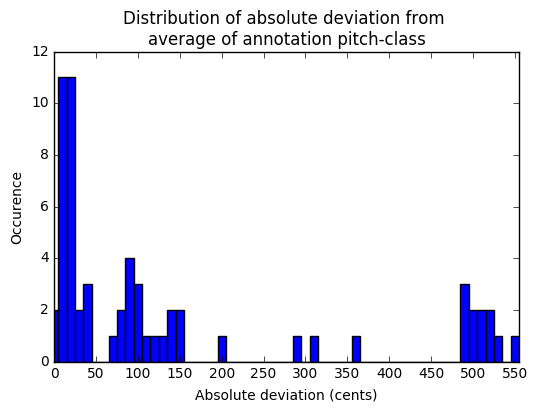

17 of 61 modifications were done within a 20 cent octave-wrapped window.
29 of 61 modifications were done within a 50 cent octave-wrapped window.


In [8]:
dev_dist = PitchDistribution.from_cent_pitch(
    cent_dev, step_size=10, kernel_width=0, norm_type=None)
dev_dist.bar()
plt.title('Distribution of absolute deviation from \naverage of annotation pitch-class')
plt.xlabel('Absolute deviation (cents)')
plt.xlim([min(dev_dist.bins), max(dev_dist.bins) + dev_dist.step_size/2])
plt.xticks(np.arange(0, 600, 50))
plt.show()

print("%d of %d modifications were done within a 20 cent octave-wrapped window."
      % (sum(c < 20 for c in cent_dev), len(cent_dev)))
print("%d of %d modifications were done within a 50 cent octave-wrapped window."
       % (sum(c < 50 for c in cent_dev), len(cent_dev)))


As can be seen above, almost half of the modifications were simply refinements on the annotation. This is understandable given the rigor of the task for humans. Below, we list some of the issues:

- Due to quality, the tonic of historical recordings may be hard to annotate accurately. Moreover the playback speed and hence the tonic frequency may not be very stable in many historical recordings. Many annotators disregard these factors. It is typically better to avoid historical recordings, if the annotator is not highly trained (or disciplined).
- Heterophonic recordings could be challenging due to the complex interactions between musical sources.
- As the annotators label more, they will get better through practice. Therefore, it is possible for an annotator to do more mistakes in the start. On the other hand, annotating without pausess for a long time will increase the cognitive fatigue (and boredom), which might make an annotator make more mistakes than usual.
- The makam performances typically finish on the tonic note. Therefore, annotating the tonic pitch/pitch-class from the final note is the most straightforward way for manual annotation. Nevertheless, the musicians may rarely choose to finish in another note for artistic purposes (you can listen to [this recording of Neva Saz Semaisi](http://musicbrainz.org/recording/132cb194-c083-4002-9cc9-720b8cbfc61c) as an example). Unless they are highly trained on makams, many annotators will not notice this artistic decision.

As discussed earlier, score-informed tonic identification method (Şentürk, S., Gulati, S., and Serra, X., 2013) typically outputs more accurate results than human annotators. Moreover, it is much faster than the humans. When there are multiple performances, the method can identify the tonic for each sub-performance separately. This case will be extra tedious for humans as they have to identify the time-intervals of the sub-performances first. Therefore, using this method is much cheaper, rapid and reliable, when the music score of a composition performed in a recording is available.

Reference
----------
Şentürk, S., Gulati, S., and Serra, X. (2013). Score informed tonic identification for makam music of Turkey. In Proceedings of 14th International Society for Music Information Retrieval Conference (ISMIR 2013), pages 175–180, Curitiba, Brazil.